In [ ]:
%load_ext Cython

# Table of Contents
- **<a href='#intro'>Intro to SQL</a>**<br>
- **<a href='#universe'>Where are we in the Universe?</a>**<br>
- **<a href='#merge'>Pandas Merge</a>**<br>
- **<a href='#pivot'>Pandas Pivot Tables</a>**<br>
- **<a href='#pivot'>Exercise: Baseball Play By Play</a>**<br>
- **<a href='#git'>Intro to Git</a>**<br>
- **<a href='#cython'>Cython</a>**<br>
- **<a href='#scrape'>Web Scraping</a>**<br>
- **<a href='#afternoon1'>Afternoon Project I: Baseball</a>**<br>
- **<a href='#afternoon2'>Afternoon Project II: Airline Routes</a>**<br>



# Intro to SQL

```SELECT * FROM PLAYER_DATA```

```SELECT * FROM GAMES_DATA```

```
     PLAYER_DATA                     GAMES_DATA
----------------------       --------------------------
| NAME HEIGHT WEIGHT |       | NAME  TIME  SHOT  MADE | 
| Jon   6.8    220   |       | Jon   0:30  22ft   0   |
| Joe   6.5    200   |       | Jon   1:44   5ft   1   |
| Sam   6.5    190   |       | Jon   9:13   9ft   1   |
| Mat   6.7    210   |       | Mat   5:50  10ft   0   |
| ...   ...    ...   |       | ...   ....  ....  ...  |
----------------------       --------------------------
```

## Lets imagine you want to find out if Height (*Player_Data*) correlates with Shots Made (*GAMES_DATA*)

- Then you would want to "join" these two tables

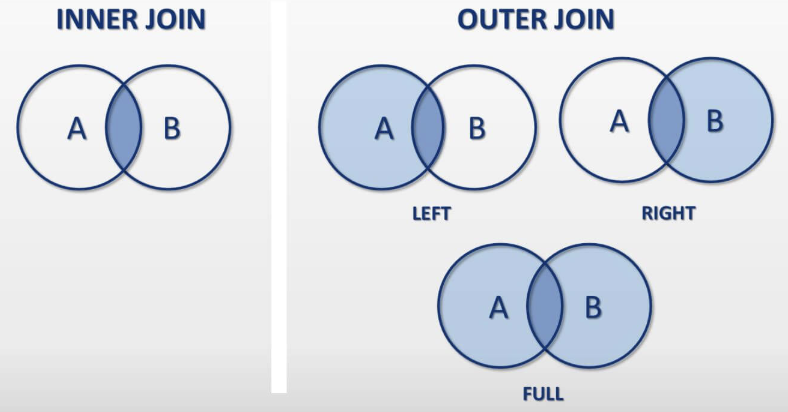

### How would you do it? Well, you'd look for rows with the same name (must be a unique identifier)

```
SELECT PLAYER_DATA.NAME as name, PLAYER_DATA.HEIGHT as height, GAMES_DATA.SHOT as dist, GAMES_DATA.MADE as made
FROM GAMES_DATA
INNER JOIN PLAYER_DATA
ON GAMES_DATA.NAME = PLAYER_DATA.NAME 
```
would give the a joined result:

```
         RESULT                        
--------------------------          
| NAME HEIGHT  dist  made |    
| Jon   6.8    22ft   0   |   
| Jon   6.8     5ft   1   |     
| Jon   6.8     9ft   1   |    
| Mat   6.7    10ft   0   |   
| ...   ...    ...   ...  |    
--------------------------       
```

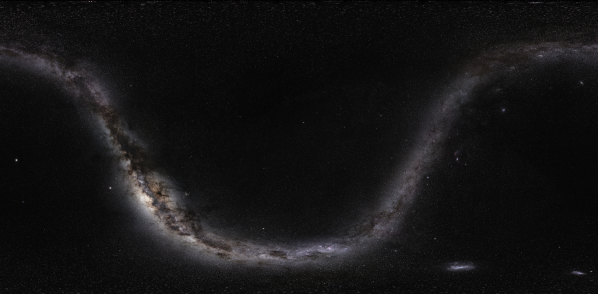
# Exercise: Where are we in the universe?

Selecting the top million stars from Gaia DR2 with luminosity less than four times the sun.

```
SELECT TOP 1000000 gaia.ra, gaia.dec 
FROM gaiadr2.gaia_source AS gaia 
WHERE gaia.lum_val < 4```

https://gea.esac.esa.int/archive/

In [ ]:
import pandas as pd
stars = pd.read_csv('../input/where-are-we/stars.csv')
stars.count() #ra and dec are again the positions on the sky

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#lets select ten thousand random stars to plot... one million would be a lot on a single plot
xx = np.random.uniform(low=0,high=len(stars['ra']),size=10000).astype(int)

plt.figure(figsize=(10,6))
plt.plot(stars['ra'][xx], stars['dec'][xx], '.', alpha=0.5)
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)');

There is a hint of structure... lets do a kde.

In [ ]:
import seaborn as sbn
plt.figure(figsize=(10,6))
sbn.kdeplot(stars['ra'][xx],stars['dec'][xx],shade=True)
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)');

Ok, but now, what happens if we choose the top 100000 Cepheids? (Cepheids are young and live in the plane of our galaxy)

We'll have to do an inner join to find the positions of the cepheids. We'll use ```source_id``` as our unique identifier to join on.

The query is

```
SELECT TOP 100000 gaia.ra, gaia.dec 
FROM gaiadr2.gaia_source AS gaia 
INNER JOIN gaiadr2.vari_cepheid AS cepheid 
ON gaia.source_id = cepheid.source_id```

In [ ]:
cepheids = pd.read_csv('../input/where-are-we/cepheids.csv')
plt.figure(figsize=(10,6))
plt.plot(cepheids['ra'], cepheids['dec'], '.', alpha=0.5)
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')

That looks like our galaxy! Lets overplot them for good measure

In [ ]:
plt.figure(figsize=(10,6))
sbn.kdeplot(stars['ra'][xx],stars['dec'][xx],shade=True,label='All Stars')
plt.plot(cepheids['ra'], cepheids['dec'], '.', alpha=0.5, label='Cepheid Stars')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.legend();

# Pandas is capable of performing similar to SQL

In [ ]:
#notice that Eric is not in df2 and that bob works in accounting and HR
df1 = pd.DataFrame({'employee': ['Bob', 'Bob', 'Jake', 'Lisa', 'Sue', 'Eric'],
                    'group': ['Accounting', 'HR', 'Engineering', 'Engineering', 'HR', 'Shipping']})
df2 = pd.DataFrame({'employee': ['Lisa', 'Bob', 'Jake', 'Sue'],
                    'hire_date': [2004, 2008, 2012, 2014]})
display(df1,df2)

In [ ]:
pd.merge(df1, df2, on='employee', how='right') 

# The Split-Apply-Combine techinque

## Dillon: dont forget to draw on the board!

this technique is useful because pandas/numpy can potentially parallelize for speed improvements.

### Aggregation/Apply

In [ ]:
import seaborn as sns
planets = sns.load_dataset('planets')
planets.head()

In [ ]:
planets.groupby('method')[['orbital_period']].median()

In [ ]:
planets.groupby('method')[['year']].describe()

In [ ]:
planets.groupby('method')[['distance']].describe()

We can also filter at the apply stage. So if for example we wanted only the scientific methods that find planets on average greater than 1000.

In [ ]:
def filter_func(x):
    return np.mean(x['distance']) >1000

In [ ]:
planets.groupby('method').filter(filter_func)
#planets.groupby('method').filter(filter_func).groupby('method').describe()['distance']


# Exercise: Data Scientist Compensation

In [ ]:
!ls ../input

In [ ]:
import pandas as pd
salary = pd.read_csv('../input/kaggle-survey-2017-response/salary.csv')
# people responded from many different countries
# here are rough conversion rates
rates=pd.read_csv('../input/kaggle-survey-2017-response/conversionRates2017.csv')


### How much were data scientists paid?
- plot the histogram of salaries in US dollars
- plot a bar chart of median US dollar salary for each country

# Very Short Intro to Git

https://www.kaggle.com/dbrout/intro-to-git

# Speeding up code

## Pandas eval()

In [ ]:
#lets make a bunch of big dataframes
import pandas as pd
nrows, ncols = 100000, 1000
rng = np.random.RandomState(42)
df1, df2, df3, df4 = (pd.DataFrame(rng.rand(nrows, ncols))
                      for i in range(4))


In [ ]:
#ordinary operations
%timeit df1 + df2 + df3 + df4

In [ ]:
#python eval()
%timeit pd.eval('df1 + df2 + df3 + df4')

The main reason why this achieves better performance than standard is that it avoids allocating memory for intermediate results. 

# Map and Numpy Vectorize (to replace for loops)

In [ ]:
import numpy as np
from math import sin 

# Define a custom function with some if-else loops
def myfunc(x,y):
    if (x>0.5*y and y<0.3):
        return (sin(x-y))
    elif (x<0.5*y):
        return 0
    elif (x>0.2*y):
        return (2*sin(x+2*y))
    else:
        return (sin(y+x))

In [ ]:
def forloop(xvec,yvec):
    result = []
    for x,y in zip(xvec,yvec):
        result.append(myfunc(x,y))
    return result

In [ ]:
xvec = np.random.randn(1000)
yvec = np.random.randn(1000)



In [ ]:
print("Time taken by the plain vanilla for-loop")
%timeit forloop(xvec,yvec)

In [ ]:
# Map() function
print("Time taken by python map function\n")
%timeit list(map(myfunc,xvec,yvec))

In [ ]:
# Numpy.vectorize method
print("Time taken by numpy.vectorize method")
vectfunc = np.vectorize(myfunc)
%timeit list(vectfunc(xvec,yvec))

# Cython

Lets imagine you have some complex code that you've written. Here we'll just implement matrix multiplication:
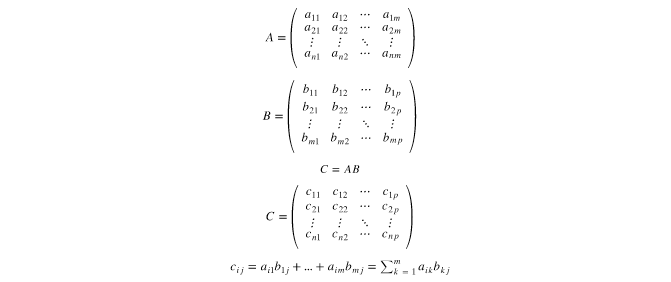

In [ ]:
def mat_mul_python(A, B):
    # Make a NxN matrix C, Filled with 0.0
    C = [[0.0 for i in range(len(A))] for j in range(len(A))]
    # Loop over columns of A, and Rows of B
    for i in range(len(A)):
        # Loop over rows of A, and columns of B
        for j in range(len(A)):
            # Do final summation of each element
            for k in range(len(A)):
                C[i][j] += A[i][k] * B[k][j]
    return C

In [ ]:
size=256
A = np.random.random((size,size))
B = np.random.random((size,size))

In [ ]:
print('Standard Python')
%time x = mat_mul_python(A,B)

In [ ]:
%%cython
# ^ This is the only thing we added

def mat_mul_cython(A, B):
    # Make a NxN matrix C, Filled with 0.0
    C = [[0.0 for i in range(len(A))] for j in range(len(A))]
    # Loop over columns of A, and Rows of B
    for i in range(len(A)):
        # Loop over rows of A, and columns of B
        for j in range(len(A)):
            # Do final summation of each element
            for k in range(len(A)):
                C[i][j] += A[i][k] * B[k][j]
    return C


In [ ]:
print('Standard Python')
%time x = mat_mul_cython(A,B)

In [ ]:
%%cython -a
# ^ This is the only thing we added

def mat_mul_cython(A, B):
    # Make a NxN matrix C, Filled with 0.0
    C = [[0.0 for i in range(len(A))] for j in range(len(A))]
    # Loop over columns of A, and Rows of B
    for i in range(len(A)):
        # Loop over rows of A, and columns of B
        for j in range(len(A)):
            # Do final summation of each element
            for k in range(len(A)):
                C[i][j] += A[i][k] * B[k][j]
    return C


In [ ]:
%%cython -a

# Arrays can be defined by the type and then [:] for 1d arrays
# 2d [:,:], 3d [:,:,:], etc.
def mat_mul_cython_fast(double [:,:] A, double [:,:] B):
    # The loop variables and the size of the array are boths ints
    cdef int i,j,k = 0
    # c arrays have a new way to get lengths, shape
    cdef int size = A.shape[0]
    C = [[0.0 for i in range(size)] for j in range(size)]
    for i in range(size):
        for j in range(size):
            for k in range(size):
                C[i][j] += A[i][k] * B[k][j]
    return C

In [ ]:
print('Cython with Pre Def')
%time x = mat_mul_cython_fast(A, B)

# Web Scraping

Static

w/ Beautiful Soup

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from tabulate import tabulate

res = requests.get("https://www.nationmaster.com/nmx/ranking/agriculture-gross-production-per-capita-index")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))
#print(df[0].columns)
print( tabulate(df[0], headers='keys', tablefmt='psql') )

# Afternoon Project I: Baseball

### please copy this notebok and dont forget to make public so the class can see.
https://www.kaggle.com/dbrout/baseball-project

# Still time? Multivariate Linear Regression to predict credit default following 360